<a href="https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/08_Julian_Stats_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
%pip install lightning torchinfo torchshow

In [3]:
# Python Standard Library
import os
from pathlib import Path

# Third Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import functional as tvF
from torchvision.transforms import Normalize

In [4]:
# Import geoguesser library
try:
  import geoguesser
  print("package installed, all good")
except ImportError as e:
  print("Installing from git repo")
  os.system("pip install git+https://github.com/lukas-gysin/bverl-miniproject")

from geoguesser.classifier import Classifier
from geoguesser.dataset import EuroSATDataset
from geoguesser.dataset import EuroSATDataLoader
from geoguesser.trainer import Trainer

package installed, all good


In [5]:
# Global Configuration
seed = 1234

sns.set_theme()

In [6]:
# Downloading the datasets
dataset_ms = EuroSATDataset.download(dataset='MS')
dataset_ms_original = EuroSATDataset.download(dataset='MS')
dataset_rgb = EuroSATDataset.download(dataset='RGB')

# Normalize MS Dataset, since some channels have really big values
values = {}
for channel in range(dataset_ms[0]['image'].size(0)):
  values[channel] = []

for idx in range(min(len(dataset_ms), 1_000)):
  observation = dataset_ms[idx]
  for channel in range(observation['image'].size(0)):
    values[channel].append(observation['image'][channel].mean())

means = []
stds = []
for channel in range(dataset_ms[0]['image'].size(0)):
  means.append(np.mean(values[channel]))
  stds.append(np.std(values[channel]))

ids = [i for i in range(len(dataset_ms))]
dataset_ms = EuroSATDataset.from_subset(dataset_ms, ids, transform=Normalize(mean=means, std=stds))

Dataset already saved in /workspace/code/data/MS.zip - not overwriting
Dataset already extracted to /workspace/code/data/MS - not overwriting
Dataset already saved in /workspace/code/data/MS.zip - not overwriting
Dataset already extracted to /workspace/code/data/MS - not overwriting
Dataset already saved in /workspace/code/data/RGB.zip - not overwriting
Dataset already extracted to /workspace/code/data/RGB - not overwriting
Created a subset with 27_000 of 27_000 images


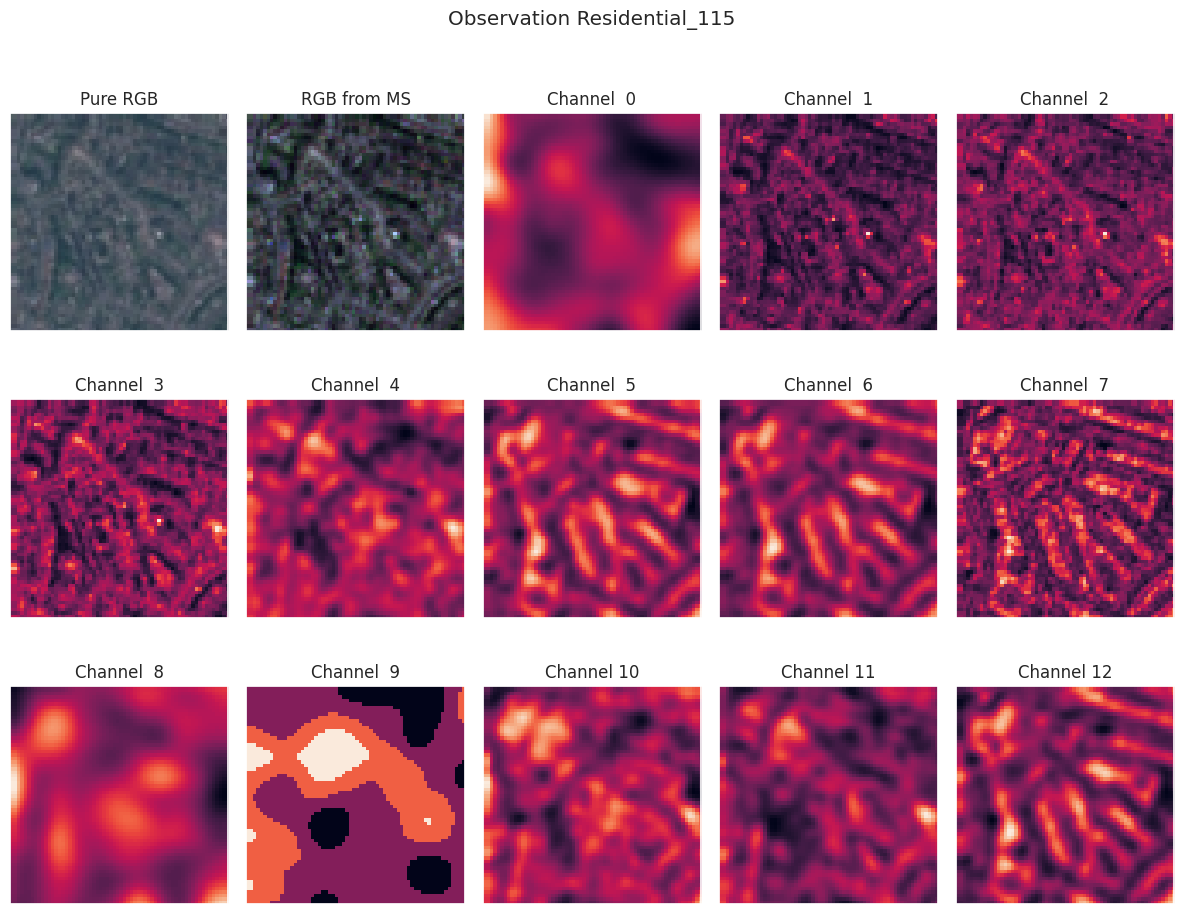

In [7]:
fig, axs = plt.subplots(figsize=(12, 10), ncols=5, nrows=3, layout='tight')
axs = axs.flatten()

observation_ms = dataset_ms[16000]
observation_rgb = dataset_rgb.get(observation_ms['file'])

fig.suptitle(f'Observation {observation_rgb["file"]}')

axs[0].imshow(tvF.to_pil_image(pic=observation_rgb['image']))
_ = axs[0].set_title(f'Pure RGB')
_ = axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ms_rgb_image = observation_ms['image'][[3,2,1]].permute(1, 2, 0)
ms_rgb_image = (ms_rgb_image - ms_rgb_image.min()) / (ms_rgb_image.max() - ms_rgb_image.min())
axs[1].imshow(ms_rgb_image)
_ = axs[1].set_title(f'RGB from MS')
_ = axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


for channel in range(observation_ms['image'].size(0)):
  axs[channel+2].imshow(observation_ms['image'][channel])
  _ = axs[channel+2].set_title(f'Channel {channel:2}')
  _ = axs[channel+2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [34]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

class Statistics:
    def __init__(self, dataset, batch_size=64, subset_ratio=None):
        self.dataset = dataset
        self.batch_size = batch_size

        # If subset_ratio is provided, subsample the dataset
        if subset_ratio:
            self.dataset = self._subset_dataset(subset_ratio)

    def _subset_dataset(self, subset_ratio):
        """Subsamples the dataset to reduce processing time."""
        subset_size = int(len(self.dataset) * subset_ratio)
        indices = torch.randperm(len(self.dataset))[:subset_size]
        return torch.utils.data.Subset(self.dataset, indices)

    def calculate_statistics(self, indices, subsample_ratio=1.0):
        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, num_workers=os.cpu_count())

        channel_sum = None
        channel_sum_sq = None
        channel_min = None
        channel_max = None
        total_pixels = 0

        skewness = None
        kurtosis = None
        correlations = None

        # Adjust indices for subsampling
        indices = indices[:int(len(indices) * subsample_ratio)]

        for batch_idx, batch in enumerate(loader):
            if batch_idx not in indices:
                continue

            images = batch["image"].to(dtype=torch.float32)  # Ensure float32 for efficiency
            if channel_sum is None:
                # Initialize accumulators
                channel_sum = torch.zeros(images.size(1))
                channel_sum_sq = torch.zeros(images.size(1))
                channel_min = torch.full((images.size(1),), float("inf"))
                channel_max = torch.full((images.size(1),), float("-inf"))
                skewness = torch.zeros(images.size(1))
                kurtosis = torch.zeros(images.size(1))
                correlations = torch.zeros((images.size(1), images.size(1)))

            # Update sums and sums of squares
            channel_sum += images.reshape(images.size(1), -1).sum(dim=1)
            channel_sum_sq += (images ** 2).reshape(images.size(1), -1).sum(dim=1)

            # Update min and max
            batch_min = images.reshape(images.size(1), -1).min(dim=1)[0]
            batch_max = images.reshape(images.size(1), -1).max(dim=1)[0]
            channel_min = torch.minimum(channel_min, batch_min)
            channel_max = torch.maximum(channel_max, batch_max)

            # Incrementally calculate skewness and kurtosis
            for i in range(images.size(1)):  # Iterate over channels
                channel_data = images[:, i, :, :].reshape(-1).cpu().numpy()
                skewness[i] += stats.skew(channel_data)
                kurtosis[i] += stats.kurtosis(channel_data)

            # Calculate correlations
            flattened = images.reshape(images.size(1), -1).cpu()
            corr_matrix = torch.corrcoef(flattened)
            correlations += corr_matrix

            # Update total pixel count
            total_pixels += images.size(0) * images.size(2) * images.size(3)

        # Calculate final statistics
        means = channel_sum / total_pixels
        stds = torch.sqrt((channel_sum_sq / total_pixels) - (means ** 2))
        correlations /= len(loader)

        print("Flattened data shape:", flattened.shape)
        print("Correlation matrix:\n", corr_matrix)
        band1 = flattened[0].numpy()
        band3 = flattened[2].numpy()
        manual_corr = stats.pearsonr(band1, band3)
        print(f"Manual correlation between Band 1 and Band 3: {manual_corr}")
        return means, stds, channel_min, channel_max, skewness / len(loader), kurtosis / len(loader), correlations

    def report(self, stats):
        means, stds, mins, maxs, skewness, kurtosis, correlations = stats
        print(f"Means: {means}")
        print(f"Standard Deviations: {stds}")
        print(f"Minimums: {mins}")
        print(f"Maximums: {maxs}")
        print(f"Skewness: {skewness}")
        print(f"Kurtosis: {kurtosis}")
        print("Correlations:")
        print(correlations)

    def visualize(self, stats):
        means, stds, mins, maxs, skewness, kurtosis, correlations = stats

        # Convert statistics to DataFrame for easy visualization
        data = pd.DataFrame({
            "Channel": [f"Band {i+1}" for i in range(len(means))],
            "Mean": means.numpy(),
            "Std Dev": stds.numpy(),
            "Min": mins.numpy(),
            "Max": maxs.numpy(),
            "Skewness": skewness.numpy(),
            "Kurtosis": kurtosis.numpy(),
        })

        # Create separate plots for each statistic
        plt.figure(figsize=(18, 12))

        # Plot Mean
        plt.subplot(3, 3, 1)
        sns.barplot(x="Channel", y="Mean", data=data)
        plt.title("Mean per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Mean")

        # Plot Standard Deviation
        plt.subplot(3, 3, 2)
        sns.barplot(x="Channel", y="Std Dev", data=data)
        plt.title("Standard Deviation per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Std Dev")

        # Plot Min
        plt.subplot(3, 3, 3)
        sns.barplot(x="Channel", y="Min", data=data)
        plt.title("Minimum Value per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Min")

        # Plot Max
        plt.subplot(3, 3, 4)
        sns.barplot(x="Channel", y="Max", data=data)
        plt.title("Maximum Value per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Max")

        # Plot Range (Max - Min)
        data["Range"] = data["Max"] - data["Min"]
        plt.subplot(3, 3, 5)
        sns.barplot(x="Channel", y="Range", data=data)
        plt.title("Range (Max - Min) per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Range")

        # Plot Skewness
        plt.subplot(3, 3, 6)
        sns.barplot(x="Channel", y="Skewness", data=data)
        plt.title("Skewness per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Skewness")

        # Plot Kurtosis
        plt.subplot(3, 3, 7)
        sns.barplot(x="Channel", y="Kurtosis", data=data)
        plt.title("Kurtosis per Channel")
        plt.xticks(rotation=45)
        plt.ylabel("Kurtosis")

        plt.tight_layout()
        plt.show()

    def visualize_correlation(self, correlations, channel_names):
        """Visualize correlation matrix as a heatmap."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlations.numpy(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=channel_names, yticklabels=channel_names)
        plt.title("Correlation Between Channels")
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()

statistics = Statistics(dataset_ms_original, batch_size=128)

In [35]:
stats = statistics.calculate_statistics(range(len(dataset_ms_original)))


Flattened data shape: torch.Size([13, 491520])
Correlation matrix:
 tensor([[ 1.0000e+00, -6.8307e-02, -2.5119e-01, -2.4849e-01,  3.9391e-01,
          1.4471e-01, -3.8035e-01, -3.1678e-01,  2.3481e-01,  5.2153e-01,
         -3.0438e-01, -2.4899e-01, -9.3404e-02],
        [-6.8307e-02,  1.0000e+00, -1.0639e-01, -3.2077e-01, -2.2737e-01,
          4.5443e-01,  1.9567e-01, -2.8934e-01, -3.1714e-01,  1.6559e-01,
          4.8867e-01, -2.6238e-01, -2.9882e-01],
        [-2.5119e-01, -1.0639e-01,  1.0000e+00, -1.1124e-01, -1.8181e-01,
         -1.8182e-01,  3.9979e-01,  7.9052e-02, -2.2727e-01, -2.2197e-01,
          1.0155e-01,  4.0599e-01, -1.6197e-01],
        [-2.4849e-01, -3.2077e-01, -1.1124e-01,  1.0000e+00, -4.4161e-02,
         -2.4118e-01, -3.4180e-01,  4.1160e-01,  1.1221e-01, -3.5555e-01,
         -3.2487e-01,  1.4707e-01,  3.7386e-01],
        [ 3.9391e-01, -2.2737e-01, -1.8181e-01, -4.4161e-02,  1.0000e+00,
         -4.9767e-02, -2.4582e-01, -2.1577e-01,  4.4715e-01,  8.7297e-

Means: tensor([1439.0204, 1446.9176, 1432.5054, 1423.5643, 1440.5674, 1439.6484,
        1423.3413, 1421.8461, 1440.6906, 1414.4423, 1430.9031, 1430.5714,
        1435.7384])
Standard Deviations: tensor([1042.0327, 1036.9194, 1032.6982, 1035.9982, 1043.0436, 1049.9172,
        1040.7911, 1038.8958, 1038.2185, 1036.4590, 1046.8575, 1041.4624,
        1043.0072])
Minimums: tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.])
Maximums: tensor([24061., 28002., 28000., 28002., 27309., 28000., 28000., 28002., 28001.,
        28003., 28000., 28002., 28002.])
Skewness: tensor([1.1499, 1.9620, 1.8602, 1.7183, 1.2860, 0.8471, 0.9018, 1.0136, 1.7114,
        2.9146, 1.2754, 1.8232, 0.9649])
Kurtosis: tensor([ 4.8753, 33.8571, 33.5539, 19.3066, 10.0173,  8.2099,  7.5983,  9.1493,
        11.8607, 23.1506, 10.5940, 15.3862,  8.7416])
Correlations:
tensor([[ 1.0000, -0.1097, -0.2646,  0.1944,  0.0667, -0.3649,  0.1394,  0.1324,
         -0.3506,  0.0635,  0.1910, -0.2651, -0.1050],
        [

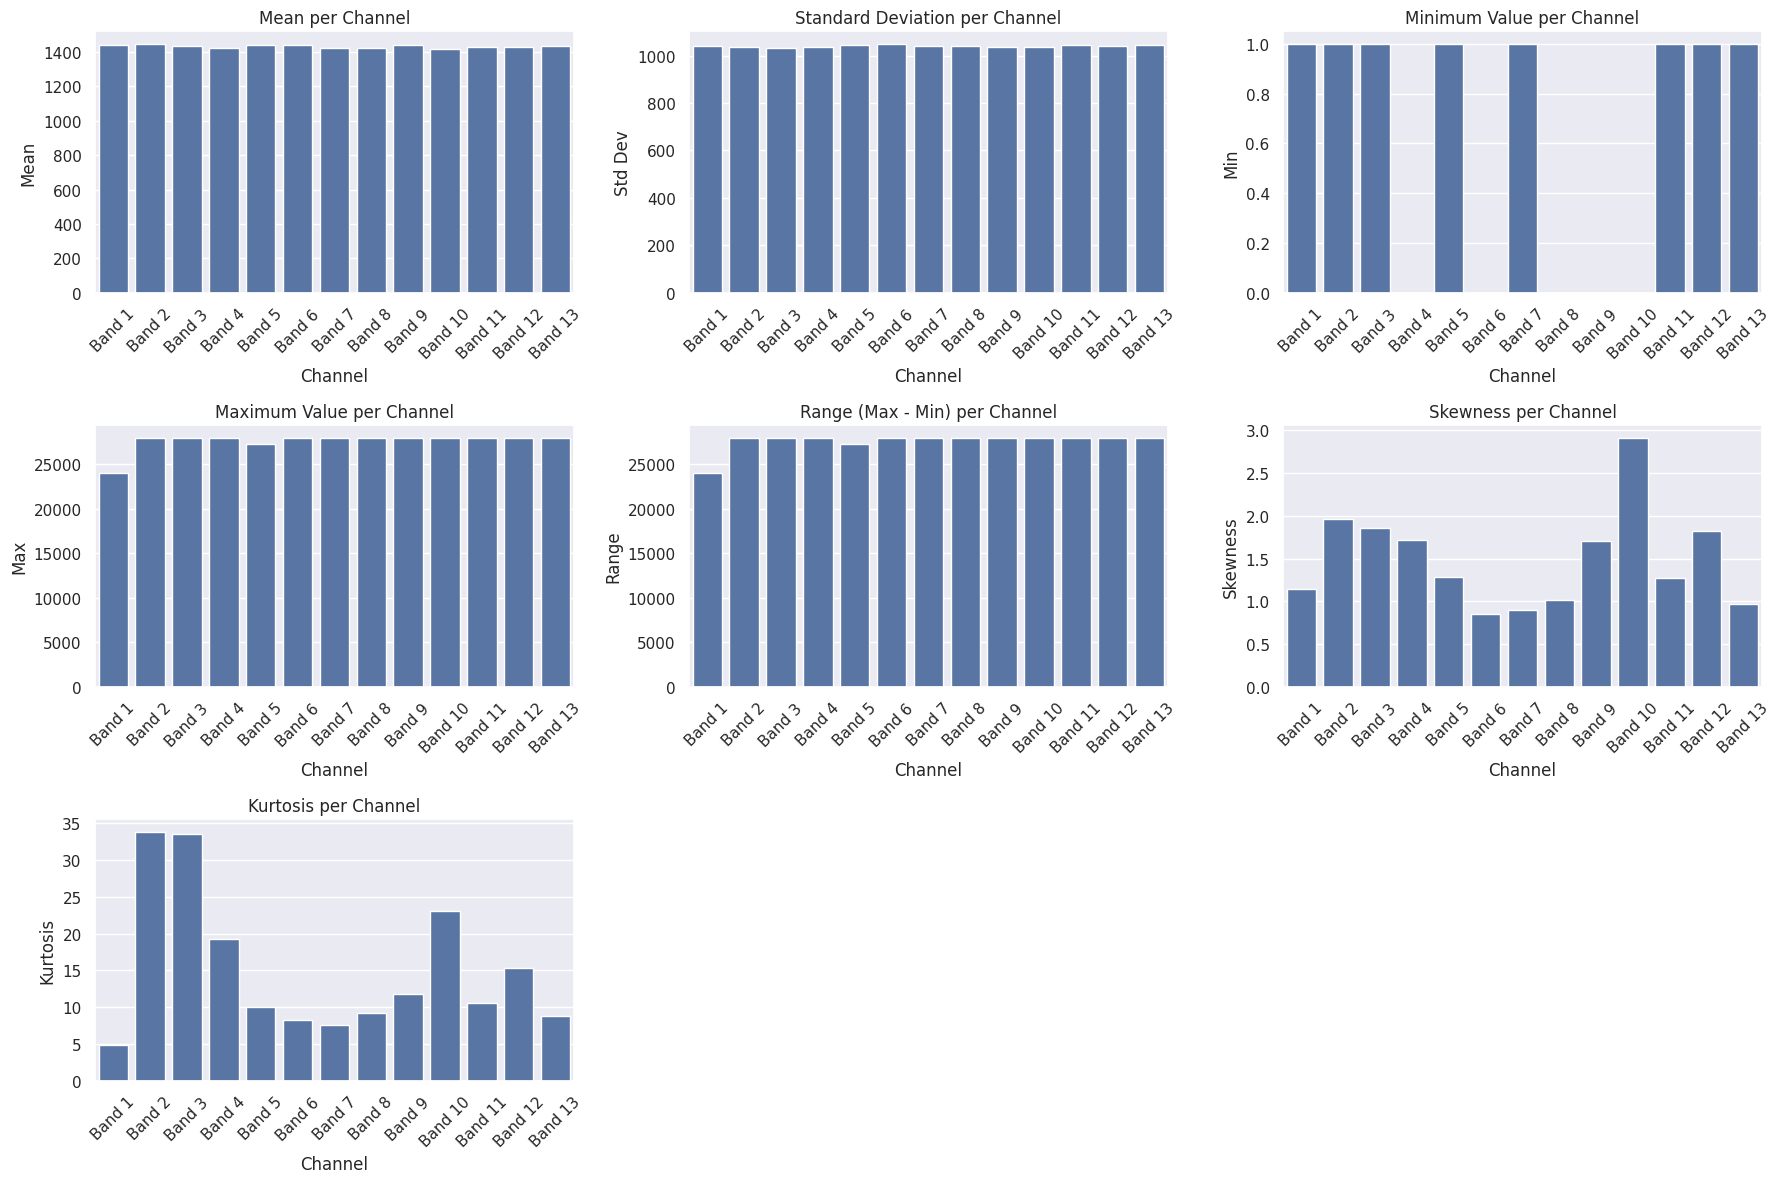

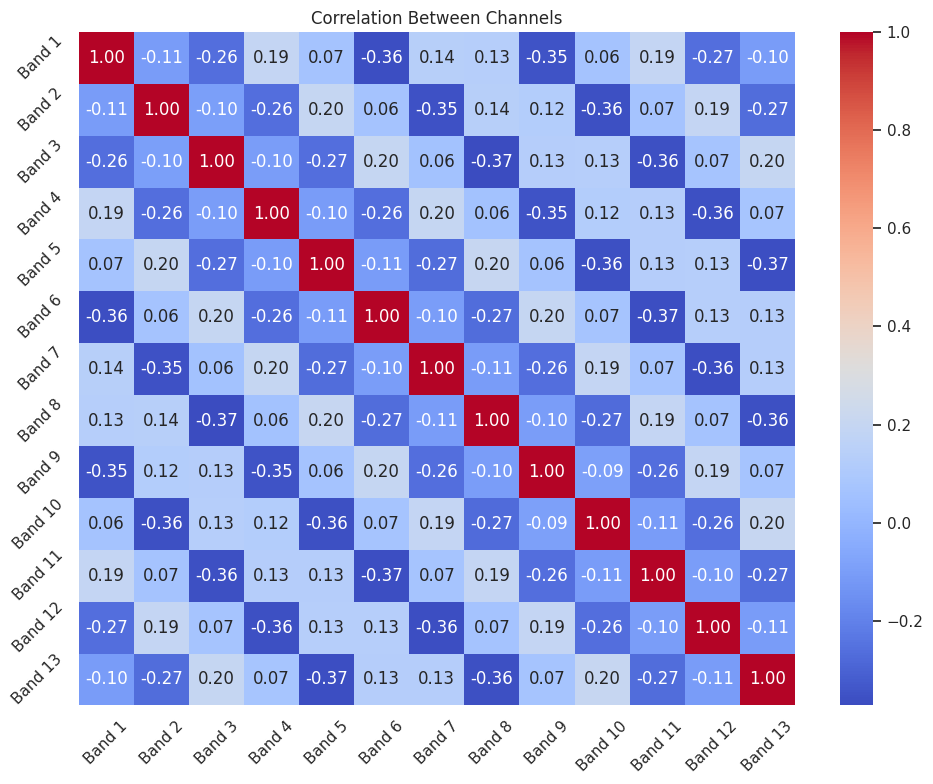

In [37]:
statistics.visualize(stats)
statistics.visualize_correlation(stats[-1], [f"Band {i+1}" for i in range(len(stats[0]))])
statistics.report(stats)